In [2]:
"""
Load, clean and merge datasets
"""
from __future__ import annotations
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import preprocessing as pp
%time
%matplotlib inline

import importlib
import utils
importlib.reload(utils)

print("Loading datasets ... ", end="")
df_merged_cleaned = utils.load_datasets(clean=True, merge=True, merge_how='left')
print("cleaning ... ", end="")
# Remove data outside 'interesting' range
df_merged_cleaned = utils.remove_outliers_range(df_merged_cleaned, 'power_dbm', (5, 125))
df_merged_cleaned = utils.remove_outliers_range(df_merged_cleaned, 'temperature', (-40, 125))
print(utils.n_unique_get(df_merged_cleaned))
print("Done!")
print(df_merged_cleaned)


CPU times: total: 0 ns
Wall time: 14.1 μs
Loading datasets ... cleaning ...          Column  Unique  Total (non-Nan)  NaN
       id_audit   45815         17588120    0
    temperature    1194         17588120    0
         sensor      71         17588120    0
  branch_header       8         17588120    0
      power_dbm     436         17588120    0
powerclass_watt       5         17588120    0
       customer       2         17588120    0
         serial   17646         17588120    0
Done!
          id_audit  temperature sensor branch_header  power_dbm  \
0              147         23.5     D4      Branch A      43.00   
1              147         23.5     D4      Branch B      43.00   
2              147         23.5     D4      Branch C      43.00   
3              147         23.5     D4      Branch D      43.00   
4              147         23.5     D4      Branch E      43.00   
...            ...          ...    ...           ...        ...   
18630828   1970516         77.8    

In [3]:
print("Aggregating data... ", end="")
df_aggregated = df_merged_cleaned.groupby('id_audit').agg({
    'temperature': ['mean', 'min', 'max', 'std'],
    'power_dbm': ['mean', 'min', 'max', 'std'],
    'sensor': lambda x: x.nunique(),  # Count unique sensors
    'serial': lambda x: x.nunique(),  # Count unique serials
    'branch_header': lambda x: x.nunique()  # Count unique branches
}).reset_index()

# Flatten multi-level columns
df_aggregated.columns = [
    '_'.join(map(str, col)).strip() if isinstance(col, tuple) else col
    for col in df_aggregated.columns
]

# Renaming a single column
df_aggregated.rename(columns={'id_audit_': 'id_audit'}, inplace=True)
print("Done")
df_aggregated.head()

Aggregating data... Done


,id_audit,temperature_mean,temperature_min,temperature_max,temperature_std,power_dbm_mean,power_dbm_min,power_dbm_max,power_dbm_std,sensor_<lambda>,serial_<lambda>,branch_header_<lambda>
0,21,29.422917,22.5,39.7,4.543689,44.5875,43.0,46.20,1.589670,48,1,8
1,23,56.420833,45.0,64.0,4.662341,46.6850,46.0,47.40,0.686222,48,1,8
2,25,63.489583,50.5,91.4,7.843515,46.6325,46.0,47.40,0.640498,48,1,8
3,147,22.608333,20.5,31.2,2.046645,43.0000,43.0,43.00,0.000000,48,1,8
4,746,40.354167,31.3,48.8,4.354138,46.7175,46.0,47.46,0.718654,48,1,8


In [4]:
# Separate id_audit from features
print("Scaling data... ", end="")
id_audit_col = df_aggregated['id_audit']  # Preserve the id_audit column
features = df_aggregated.drop(columns=['id_audit'])  # Extract only the features

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print('Done')


Scaling data... Done


In [5]:
print("Running Isolation Forest... ", end="")
isolation_forest = IsolationForest(random_state=111, contamination=0.001)
predictions = isolation_forest.fit_predict(scaled_features)

# Step 4: Add predictions back
df_aggregated['Anomaly'] = predictions  # -1 for anomalies, 1 for normal

num_anomalies = len(df_aggregated[df_aggregated['Anomaly'] == -1])
print("Done")
print(f"Number of anomalies: {num_anomalies}")

Running Isolation Forest... Done
Number of anomalies: 46


In [6]:
print("Map anomalies detected by model to original dataset... ", end="")
df_merged_cleaned = df_merged_cleaned.merge(
    df_aggregated[['id_audit', 'Anomaly']], on='id_audit', how='left'
)
# Rename anomalous values to something more sensible
df_merged_cleaned['Anomaly'] = df_merged_cleaned['Anomaly'].map({1: 'Normal', -1: 'Anomalous'})
print("Done")

Map anomalies detected by model to original dataset... Done


Plotting results...


c:\Users\ehrlcuj\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


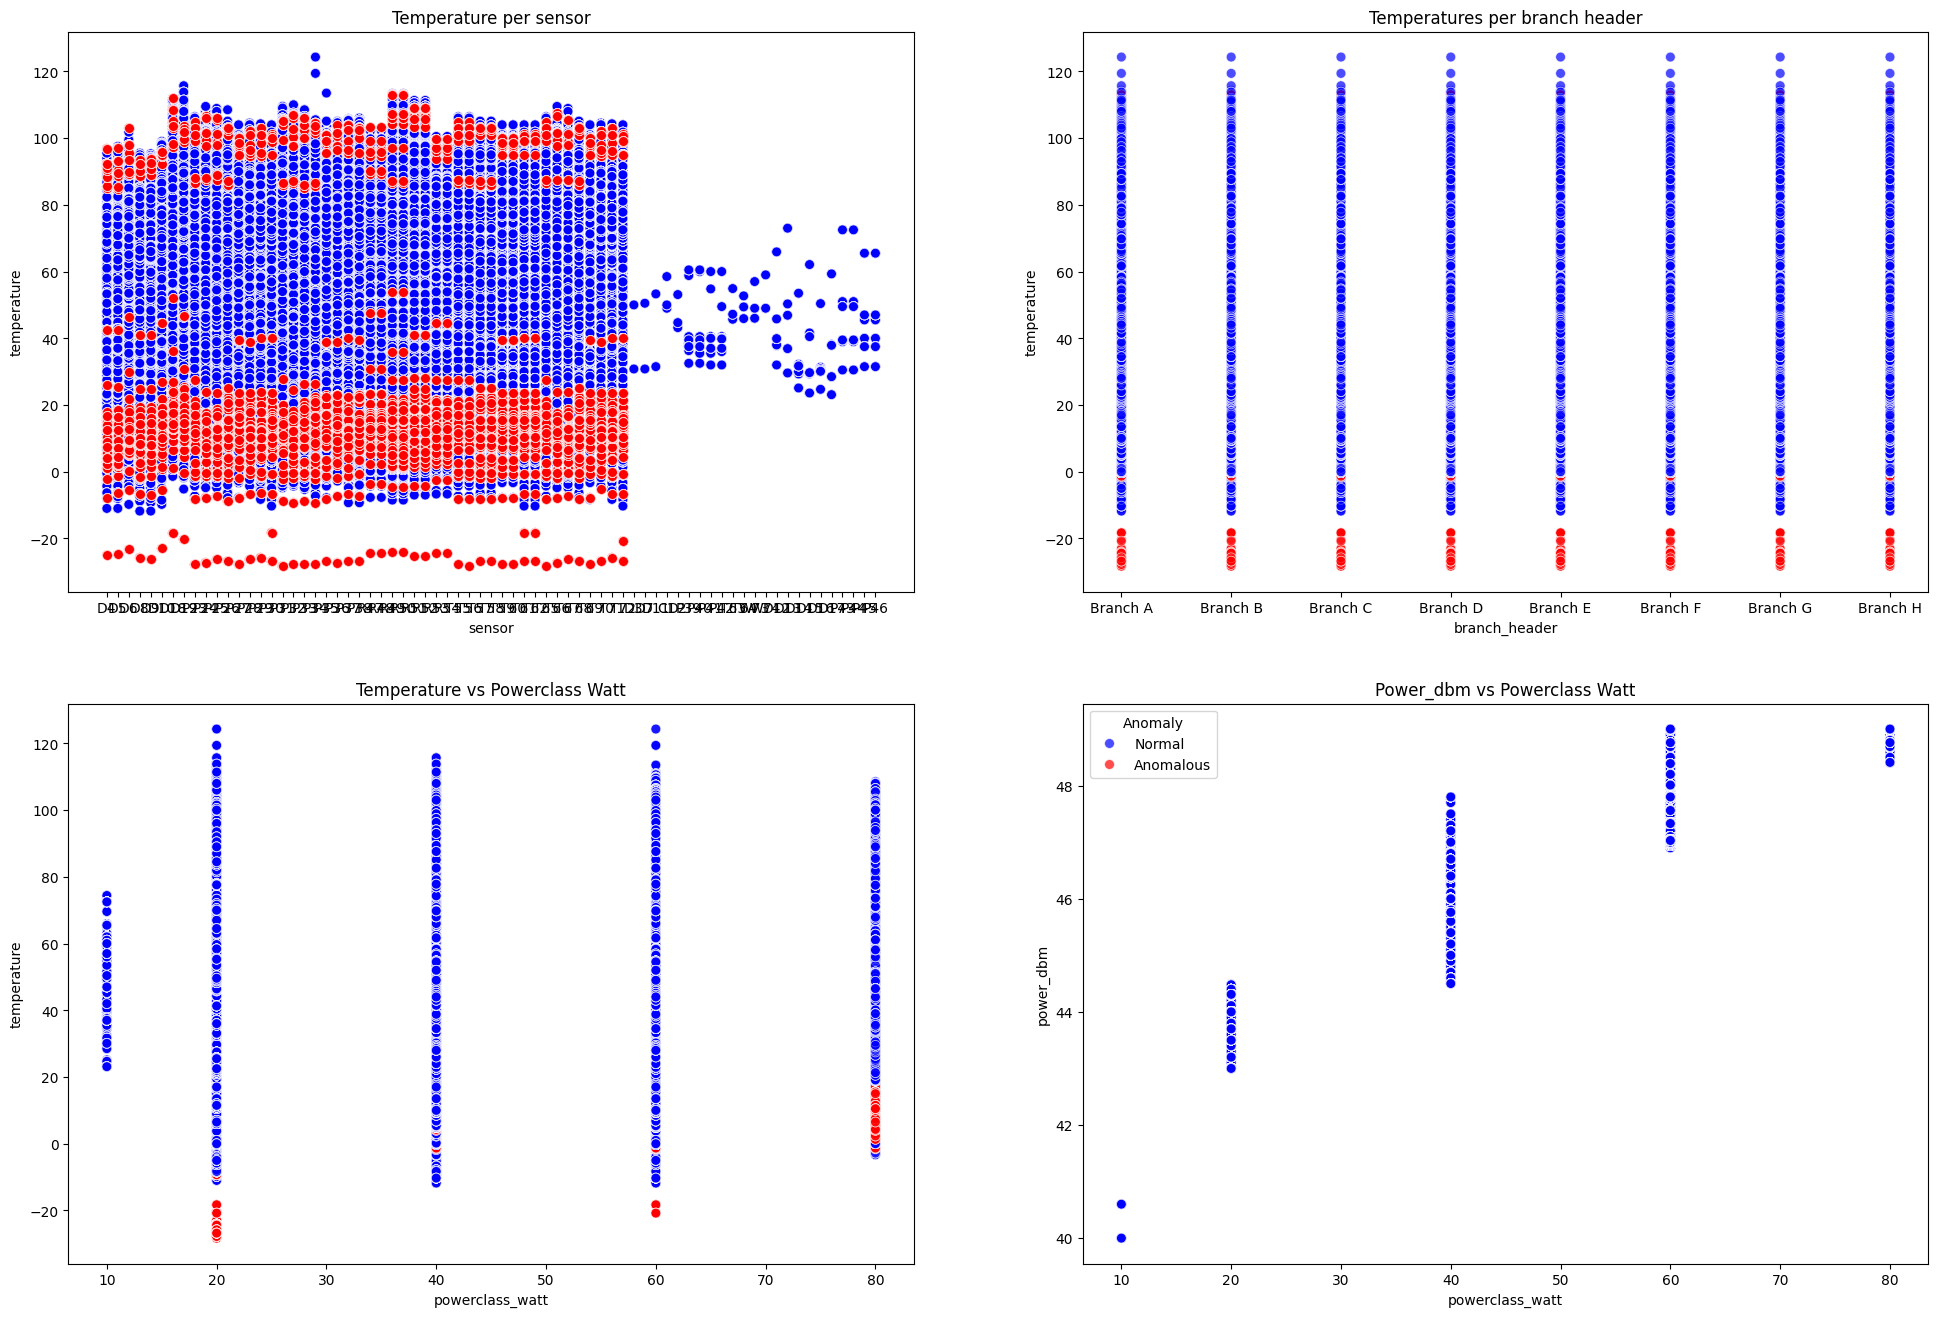

In [15]:
print("Plotting results...")

fig, axes = plt.subplots(2, 2, figsize=(24, 16))
palette = {'Normal': 'blue', 'Anomalous': 'red'}

# Top left
sns.scatterplot(
    data=df_merged_cleaned,
    x='sensor',
    y='temperature',
    hue='Anomaly',
    palette=palette,
    ax=axes[0, 0],
    alpha=0.7,
    s=50,
    legend=False
)
axes[0, 0].set_title("Temperature per sensor")

# Top right
sns.scatterplot(
    data=df_merged_cleaned,
    x='branch_header',
    y='temperature',
    hue='Anomaly',
    palette=palette,
    ax=axes[0, 1],
    alpha=0.7,
    s=50,
    legend=False
)
axes[0, 1].set_title("Temperatures per branch header")

# Bottom left
sns.scatterplot(
    data=df_merged_cleaned,
    x='powerclass_watt',
    y='temperature',
    hue='Anomaly',
    palette=palette,
    ax=axes[1, 0],
    alpha=0.7,
    s=50,
    legend=False
)
axes[1, 0].set_title("Temperature vs Powerclass Watt")

# Bottom right
sns.scatterplot(
    data=df_merged_cleaned,
    x='powerclass_watt',
    y='power_dbm',
    hue='Anomaly',
    palette=palette,
    ax=axes[1, 1],
    alpha=0.7,
    s=50,
    legend="full"
)
axes[1, 1].set_title("Power_dbm vs Powerclass Watt")

# Highlight anomalies by overlaying
anomalies = df_merged_cleaned[df_merged_cleaned['Anomaly'] == 'Anomalous']
for ax in [axes[0, 0]]:#axes.flatten():
    sns.scatterplot(
        data=anomalies,
        x=ax.get_xlabel(),
        y=ax.get_ylabel(),
        color='red',
        s=50,  # marker size
        #marker='X',  # marker shape
        ax=ax,
        label='Anomaly',
        alpha=0.5,
        legend=False
    )


#plt.tight_layout()
plt.show()

In [7]:
df_merged_cleaned[df_merged_cleaned['Anomaly'] != 'Anomalous'].head()

,id_audit,temperature,sensor,branch_header,power_dbm,powerclass_watt,customer,serial,Anomaly
0,147,23.5,D4,Branch A,43.0,20.0,2,17087,Normal
1,147,23.5,D4,Branch B,43.0,20.0,2,17087,Normal
2,147,23.5,D4,Branch C,43.0,20.0,2,17087,Normal
3,147,23.5,D4,Branch D,43.0,20.0,2,17087,Normal
4,147,23.5,D4,Branch E,43.0,20.0,2,17087,Normal


In [8]:
# Calculate the top 20 serials with the most anomalies
top_serials = (
    df_merged_cleaned[df_merged_cleaned['Anomaly'] == 'Anomalous']
    .groupby('serial')
    .size()
    .nlargest(20)
    .index
)

# Add a column to distinguish top serials and others
df_merged_cleaned['serial_group'] = df_merged_cleaned['serial'].map(
    lambda x: x if x in top_serials else 'Non-Anomalous'
)

# Create the anomaly counts dataframe and align it
anomaly_counts = (
    df_merged_cleaned[df_merged_cleaned['Anomaly'] == 'Anomalous']
    .groupby('serial')
    .size()
    .nlargest(20)
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)


In [41]:
print(top_serials)
df_top_serials = df_merged_cleaned[df_merged_cleaned['serial'].isin(top_serials)]

unique_id_audit_counts = df_top_serials.groupby('serial')['id_audit'].nunique().reset_index()
unique_id_audit_counts.columns = ['serial', 'unique_id_audit_count']
unique_id_audit_counts = pd.DataFrame(unique_id_audit_counts)
df_top_serials

Index([ 7457, 15181, 16022, 10366,   141,  1339,  1356,  1358,  2027,  2528,
        4615,  4999,  5095,  5101,  7599, 10559, 13057, 13158, 13207, 13209],
      dtype='int64', name='serial')


,id_audit,temperature,sensor,branch_header,power_dbm,powerclass_watt,customer,serial,Anomaly,serial_group
768,599167,23.8,D4,Branch A,47.8,60.0,2,15181,Normal,15181
769,599167,23.8,D4,Branch B,47.8,40.0,2,15181,Normal,15181
770,599167,23.8,D4,Branch C,47.8,40.0,2,15181,Normal,15181
771,599167,23.8,D4,Branch D,47.8,60.0,2,15181,Normal,15181
772,599167,23.8,D4,Branch E,49.0,80.0,2,15181,Normal,15181
...,...,...,...,...,...,...,...,...,...,...
15850971,1730685,23.5,T72,Branch D,43.0,20.0,2,10366,Anomalous,10366
15850972,1730685,23.5,T72,Branch E,43.0,20.0,2,10366,Anomalous,10366
15850973,1730685,23.5,T72,Branch F,43.0,20.0,2,10366,Anomalous,10366
15850974,1730685,23.5,T72,Branch G,43.0,20.0,2,10366,Anomalous,10366


C:\Users\ehrlcuj\AppData\Local\Temp\ipykernel_42624\1522968770.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ehrlcuj\AppData\Local\Temp\ipykernel_42624\1522968770.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ehrlcuj\AppData\Local\Temp\ipykernel_42624\1522968770.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


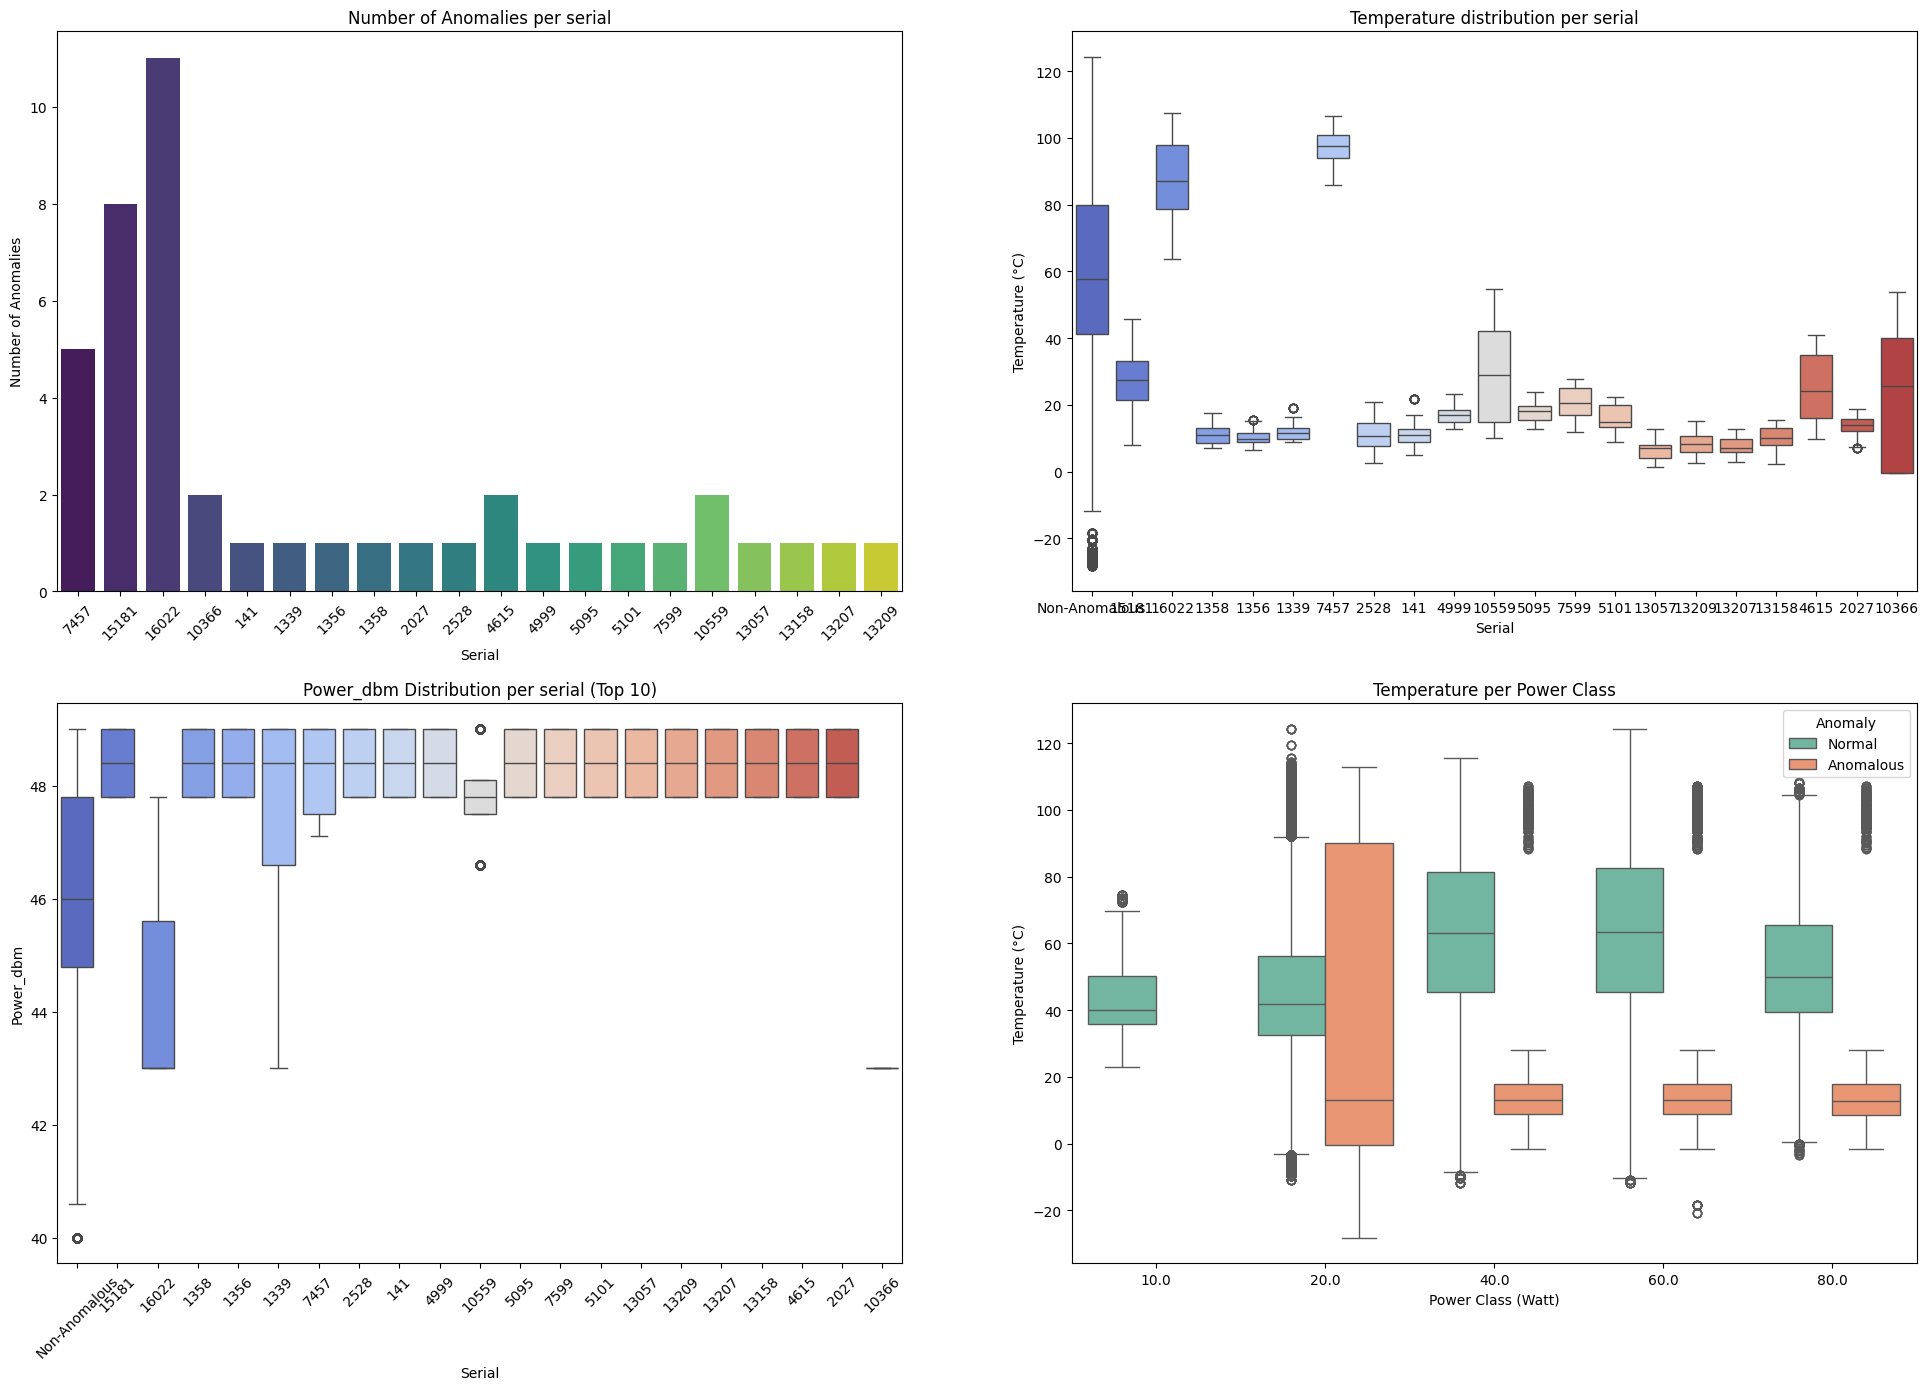

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(24, 16))

# Top left - anomalies per serial

sns.barplot(
    data=unique_id_audit_counts,
    x='serial',
    y='unique_id_audit_count',
    ax=axes[0, 0],
    palette='viridis',
    order=anomaly_counts['serial']
)
axes[0, 0].set_title("Number of Anomalies per serial")
axes[0, 0].set_xlabel("Serial")
axes[0, 0].set_ylabel("Number of Anomalies")
axes[0, 0].tick_params(axis='x', rotation=45)

# Top right:  temperature per serial group
sns.boxplot(
    data=df_merged_cleaned,
    x='serial_group',
    y='temperature',
    ax=axes[0, 1],
    palette='coolwarm'
)
axes[0, 1].set_title("Temperature distribution per serial")
axes[0, 1].set_xlabel("Serial")
axes[0, 1].set_ylabel("Temperature (°C)")


# Bottom left -= Power_dbm distribution per serial group
sns.boxplot(
    data=df_merged_cleaned,
    x='serial_group',
    y='power_dbm',
    ax=axes[1, 0],
    palette='coolwarm'
)
axes[1, 0].set_title("Power_dbm Distribution per serial (Top 10)")
axes[1, 0].set_xlabel("Serial")
axes[1, 0].set_ylabel("Power_dbm")
axes[1, 0].tick_params(axis='x', rotation=45)

# Bottom right - Temperature per power class
sns.boxplot(
    data=df_merged_cleaned,
    x='powerclass_watt',
    y='temperature',
    hue='Anomaly',
    ax=axes[1, 1],
    palette='Set2'
)
axes[1, 1].set_title("Temperature per Power Class")
axes[1, 1].set_xlabel("Power Class (Watt)")
axes[1, 1].set_ylabel("Temperature (°C)")

plt.show()


In [9]:
df_merged_cleaned.head()

,id_audit,temperature,sensor,branch_header,power_dbm,powerclass_watt,customer,serial,Anomaly,serial_group
0,147,23.5,D4,Branch A,43.0,20.0,2,17087,Normal,Non-Anomalous
1,147,23.5,D4,Branch B,43.0,20.0,2,17087,Normal,Non-Anomalous
2,147,23.5,D4,Branch C,43.0,20.0,2,17087,Normal,Non-Anomalous
3,147,23.5,D4,Branch D,43.0,20.0,2,17087,Normal,Non-Anomalous
4,147,23.5,D4,Branch E,43.0,20.0,2,17087,Normal,Non-Anomalous


In [11]:
top_serials


serial
7457     768
15181    768
16022    768
10366    688
141      384
1339     384
1356     384
1358     384
2027     384
2528     384
dtype: int64

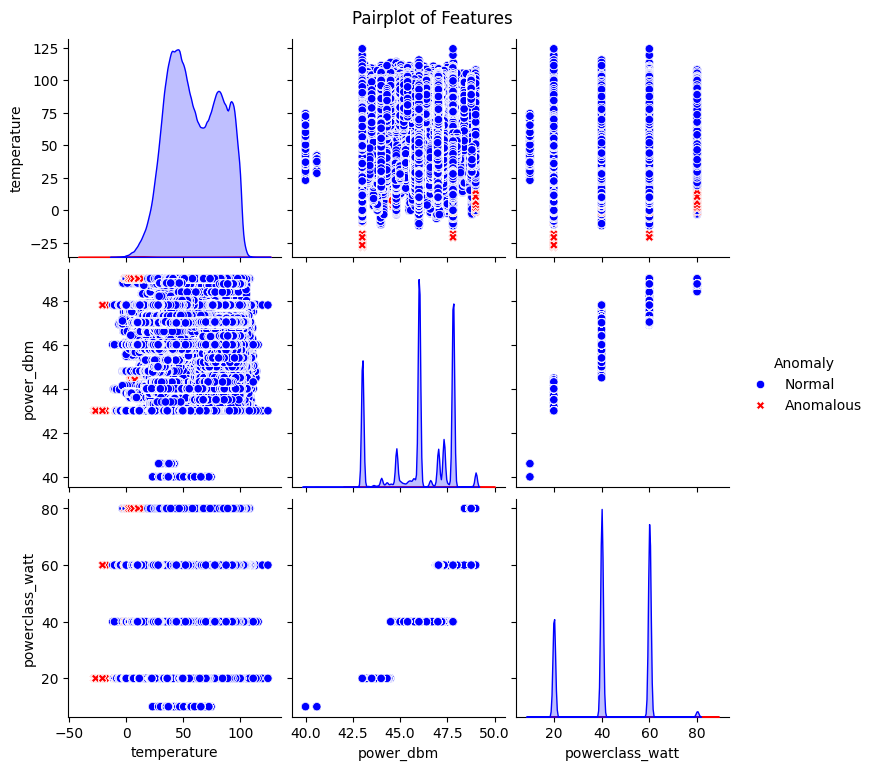

In [12]:
# Set the features you're interested in
features = ['temperature', 'sensor', 'power_dbm', 'powerclass_watt']

# 1. Pairplot with Anomaly as hue
sns.pairplot(df_merged_cleaned[features + ['Anomaly']], hue="Anomaly", markers=["o", "X"],
             palette={'Normal': 'blue', 'Anomalous': 'red'})
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()